In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [121]:
def loadFile(filename):
    fr = open(filename)
    datasets = []
    Y = []
    for line in fr.readlines():
        line = line.strip().split('\t')
        dataArray = []
        for data in line[: len(line) - 1]:
            dataArray.append(float(data))
        datasets.append(dataArray)
        Y.append(float(line[-1]))
    return np.array(datasets).T, np.array(Y).T


def normData(dataMat):
    # normalize the data
    var = np.reshape(np.var(dataMat, axis=1), (-1, 1))
    mean = np.reshape(np.mean(dataMat, axis=1), (-1, 1))
    dataNorm = (dataMat - mean) / var
    return dataNorm


def linearReg(dataMat, Y):
    # check if the first row of data is np.ones(n) n is the number of observations, if not, add one row of '1's as bias
    if np.all(dataMat[0] == np.ones(len(dataMat[0]))) == False:
        dataMat = np.vstack((np.ones(len(dataMat[0])), dataMat))
    X = dataMat
    Y = np.reshape(Y, (1, -1))
    if np.linalg.det(X.dot(X.T)) == 0:
        print("Singular Matrix")
        return
    else:
        beta = np.linalg.inv(X.dot(X.T)).dot(X).dot(Y.T)  # p * 1 matrix, p is dimension
        return beta
    
def RBF(x1, x2, k):
    return np.exp(- (x1 - x2).T.dot(x1 - x2) / (2*k**2))

def LWLR(testPoints, dataMat, Y, k):  # locally weighted linear regression
    # check if the first row of data is np.ones(n) n 
    # is the number of observations, if not, add one row of '1's as bias
    # testPoints: p*N
    testPoints = np.reshape(testPoints, (1, -1))
    if np.all(dataMat[0] == np.ones(len(dataMat[0]))) == False:
        dataMat = np.vstack((np.ones(len(dataMat[0])), dataMat))
    if np.all(testPoints[0]) == False:
        testPoints = np.vstack((np.ones(len(testPoints[0])), testPoints))
    X = dataMat
    N = len(testPoints.T)
    p, n = np.shape(X)
    betaSets = np.zeros((p, N))
    for i in range(N):
        weights = np.zeros((n, n))
        for j in range(n):
            weights[j, j] = RBF(testPoints[:, i], X[:, j], k)
        if np.linalg.det(X.dot(weights.T).dot(X.T)) == 0:
            print("Singular Matrix")
            return
        beta = np.linalg.inv(X.dot(weights.T).dot(X.T)).dot(X).dot(weights.T).dot(Y.T)
        betaSets[:, i] = beta
    predictY = []
    for beta, point in zip(betaSets.T, testPoints.T):
        predictY.append(beta.dot(point))
    return predictY
        
def ridgeRegression(dataMat, Y, lam):
    # check if the first row of data is np.ones(n) n is the number of observations, if not, add one row of '1's as bias
    if np.all(dataMat[0]) == False:
        dataMat = np.vstack((np.ones(len(dataMat[0])), dataMat))
    X = dataMat
    p, n = np.shape(X)
    if np.linalg.det(X.dot(X.T) + lam * np.ones(p)) == 0:
        print("Singular Matrix")
        return
    else:
        beta = np.linalg.inv(X.dot(X.T) + lam * np.ones(p)).dot(X).dot(Y.T)  # p * 1 matrix, p is dimension
        return beta
    
def ridgeTest(dataMat, Y, lam):
    dataNorm = normData(dataMat)
    betaSets = []
    for i in lam:
        beta = ridgeRegression(dataNorm, Y, i)
        betaSets.append(beta.T)
    return np.array(betaSets)
   

def ssqError(Y, Ypredict): 
    return np.sum((Y - Ypredict)**2)

def stageWise(dataMat, Y, eps=0.01, numIte=100):
    # check if the first row of data is np.ones(n) n is 
    #the number of observations, if not, add one row of '1's as bias
    if np.all(dataMat[0]) == False:
        dataMat = np.vstack((np.ones(len(dataMat[0])), dataMat))
    dataNorm = normData(dataMat)
    X = dataNorm
    p, n = np.shape(X)
    Y = np.reshape(Y, (1, -1))
    lowestError = np.inf # initialize the lowest error
    beta = np.ones((p, 1))  # initialize the weights array
    bestBeta = np.ones((p, 1))
    weights = np.zeros((numIte, p))
    for ite in range(numIte):
        for i in range(p):
            for sign in [1, -1]:
                beta[i] += sign * eps
                predictY = beta.T.dot(X)
                error = ssqError(Y, predictY)
                if error < lowestError:
                    lowestError = error
                    bestBeta = beta
        weights[ite] = bestBeta.T
    return weights

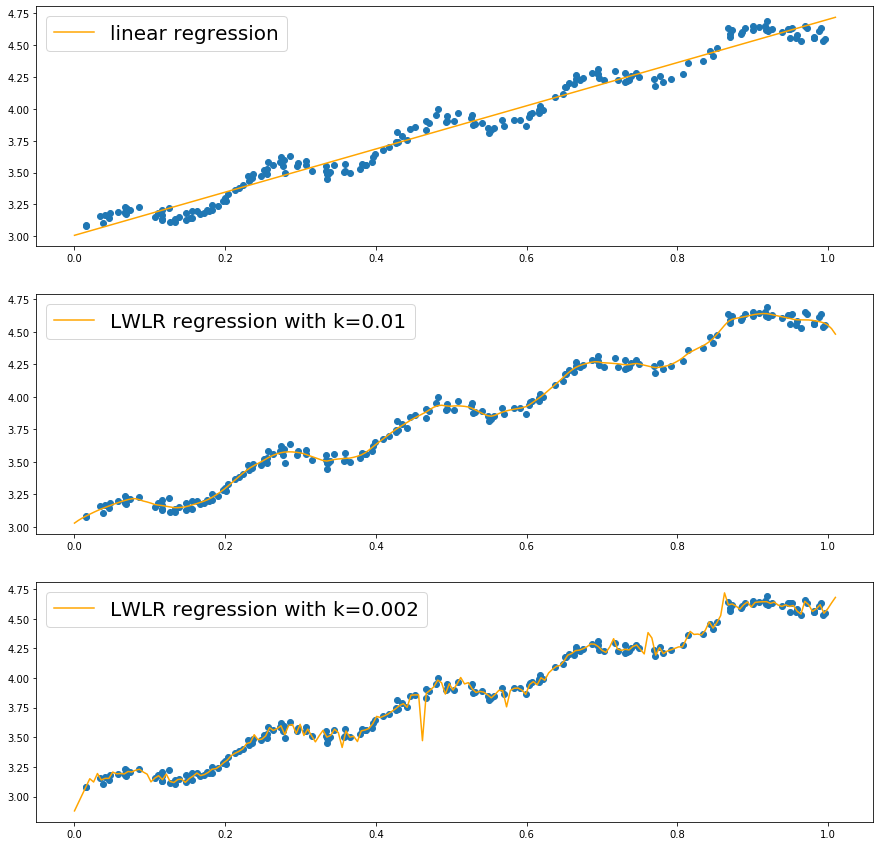

In [122]:
filename = 'ex0.txt'
dataMat, Y = loadFile(filename)
beta = linearReg(dataMat, Y) 
x = np.linspace(0, 1.01, 200)
predictY_LWLR = LWLR(x, dataMat, Y, 0.01)
predictY_LWLR1 = LWLR(x, dataMat, Y, 0.002)
predictY = beta[0] + beta[1] * x

fig, axes = plt.subplots(3, 1)
axes[0].scatter(dataMat[1], Y)
axes[0].plot(x, predictY, color='orange', label='linear regression')
axes[1].scatter(dataMat[1], Y)
axes[1].plot(x, predictY_LWLR, color='orange', label='LWLR regression with k=0.01')
axes[2].scatter(dataMat[1], Y)
axes[2].plot(x, predictY_LWLR1, color='orange', label='LWLR regression with k=0.002')
for i in range(3):
    axes[i].legend(loc='best', fontsize=20)
plt.rc('figure', figsize=(15, 15))

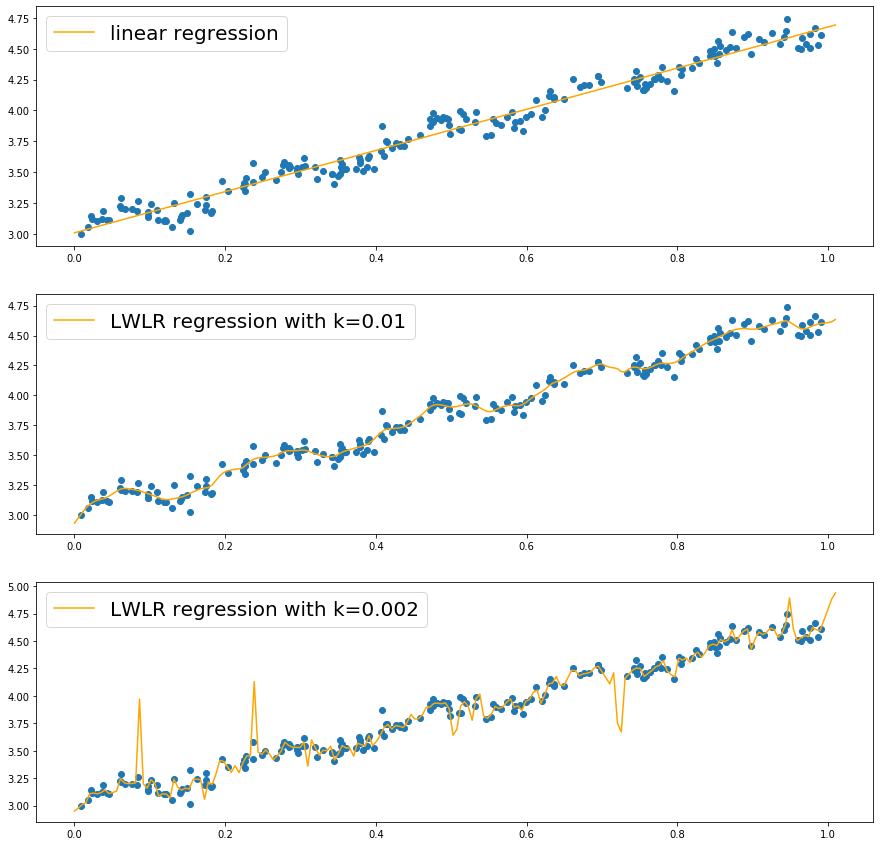

In [123]:
filename = 'ex1.txt'
dataMat, Y = loadFile(filename)
beta = linearReg(dataMat, Y) 
x = np.linspace(0, 1.01, 200)
predictY_LWLR = LWLR(x, dataMat, Y, 0.01)
predictY_LWLR1 = LWLR(x, dataMat, Y, 0.002)
predictY = beta[0] + beta[1] * x

fig, axes = plt.subplots(3, 1)
axes[0].scatter(dataMat[1], Y)
axes[0].plot(x, predictY, color='orange', label='linear regression')
axes[1].scatter(dataMat[1], Y)
axes[1].plot(x, predictY_LWLR, color='orange', label='LWLR regression with k=0.01')
axes[2].scatter(dataMat[1], Y)
axes[2].plot(x, predictY_LWLR1, color='orange', label='LWLR regression with k=0.002')
for i in range(3):
    axes[i].legend(loc='best', fontsize=20)

(11, 8)


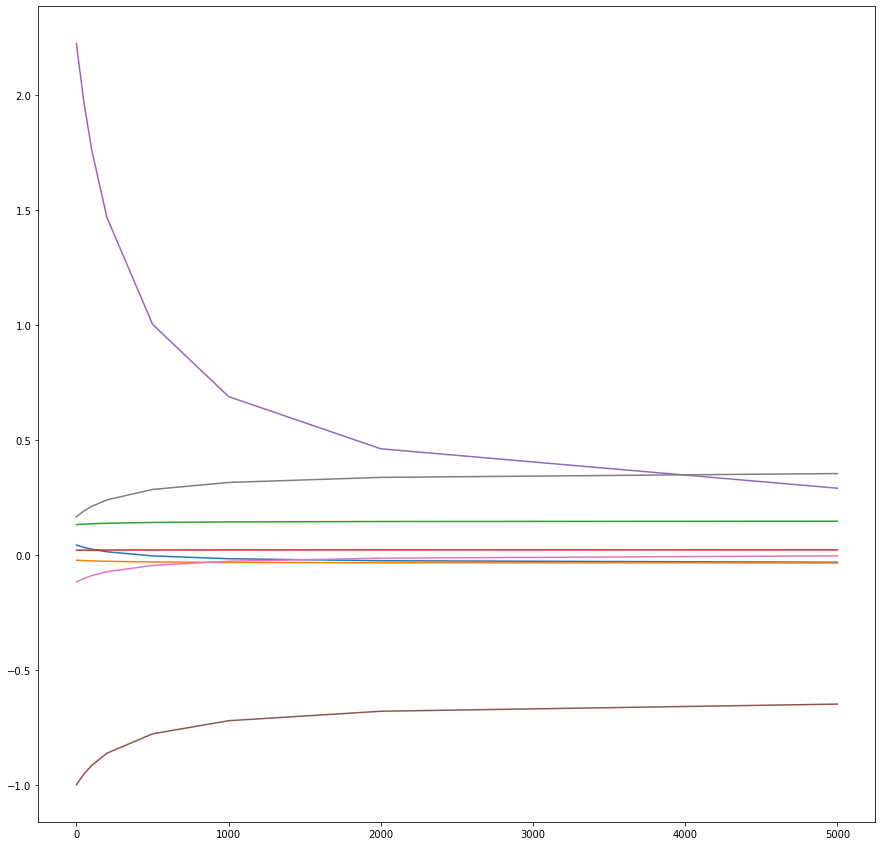

In [124]:
# ridge regression
filename = 'abalone.txt'
datasets, ages = loadFile(filename)
lam = np.array([0.1, 1, 5, 10, 50, 100, 200, 500, 1000, 2000, 5000])
betaSets = ridgeTest(datasets, ages, lam)
print(np.shape(betaSets))
for i in range(len(datasets)):
    plt.plot(lam, betaSets[:, i])

# Predicting the price of a Lego toy set

In [168]:
from bs4 import BeautifulSoup

def scrapePage(inFile,outFile,yr,numPce,origPrc):
    fr = open(inFile,'r',encoding= 'utf8'); fw=open(outFile,'a') #a is append mode writing
    soup = BeautifulSoup(fr.read())
    i=1
    currentRow = soup.findAll('table', r="%d" % i)
    while(len(currentRow)!=0):
        title = currentRow[0].findAll('a')[1].text
        lwrTitle = title.lower()
        if (lwrTitle.find('new') > -1) or (lwrTitle.find('nisb') > -1):
            newFlag = 1.0
        else:
            newFlag = 0.0
        soldUnicde = currentRow[0].findAll('td')[3].findAll('span')
        if len(soldUnicde)==0:
            print("item #%d did not sell" % i)
        else:
            soldPrice = currentRow[0].findAll('td')[4]
            priceStr = soldPrice.text
            priceStr = priceStr.replace('$','') #strips out $
            priceStr = priceStr.replace(',','') #strips out ,
            if len(soldPrice)>1:
                priceStr = priceStr.replace('Free shipping', '') #strips out Free Shipping
            print("%s\t%d\t%s" % (priceStr,newFlag,title))
            fw.write("%d\t%d\t%d\t%f\t%s\n" % (yr,numPce,newFlag,origPrc,priceStr))
        i += 1
        currentRow = soup.findAll('table', r="%d" % i)
    fw.close()
        
def setDataCollect(retX, retY):
    scrapePage("setHtml/lego8288.html","data/lego8288.txt",2006, 800, 49.99)
    scrapePage("setHtml/lego10030.html","data/lego10030.txt", 2002, 3096, 269.99)
    scrapePage("setHtml/lego10179.html","data/lego10179.txt", 2007, 5195, 499.99)
    scrapePage("setHtml/lego10181.html","data/lego10181.txt", 2007, 3428, 199.99)
    scrapePage("setHtml/lego10189.html","data/lego10189.txt", 2008, 5922, 299.99)
    scrapePage("setHtml/lego10196.html","data/lego10196.txt", 2009, 3263, 249.99)
    

def crossValidation(datasets, labels, lam, numVal=10):
    dataNorm = normData(datasets)
    p, n = np.shape(dataNorm)
    index = np.arange(n)
    error = 0
    for num in range(numVal):
        sortIndex = np.random.permutation(index)
        trainSets = dataNorm[:, sortIndex[:int(0.9*n)]]
        testSets = dataNorm[:, sortIndex[int(0.9*n):]]
        trainLables = labels[sortIndex[:int(0.9*n)]]
        testLables = labels[sortIndex[int(0.9*n):]]
        betaSets = ridgeTest(trainSets,trainLables, lam)
        error += abs(betaSets.dot(testSets) - testLables)
    errorMean = np.sum(error, axis=1) / numVal # average errors for each lambda
    bestLambda = lam[np.argsort(errorMean)[0]]
    return bestLambda
        

In [61]:
lgX = []; laY = []

setDataCollect(lgX, laY)
#xmat,ymat = loadDataSet("legoAllData.txt")

85.00	0	Lego Technic 8288 Crawler crane
102.50	0	Lego Technic 8288 Crawler Crane USED SET 
77.00	0	Lego Technic 8288 Crawler Crane
item #4 did not sell
162.50	0	RARE Lego Technic 8288 Crawler Crane
699.99	0	Lego Star Wars Imperial Star Destroyer (10030)  Sealed!
602.00	0	Lego Star Wars UCS Imperial Star Destroyer #10030
515.00	0	Lego 10030 Imperial Star Destroyer 
510.00	0	Lego Star Wars 10030 Ultimate Imperial Star Destroyer
375.00	0	Lego Star Wars Imperial Star Destroyer (10030)
1050.00	1	LEGO STAR DESTROYER NEW IN SEALED BOX 10030 STAR WARS
740.00	0	IMPERIAL STAR DESTROYER #10030 Lego Star Wars   SEALED 
759.00	1	LEGO STAR WARS 10030 UCS IMPERIAL DESTROYER NISB NEW
730.00	0	Lego 10030 Star Destroyer, MISB, Old Gray, Ships Free!
750.00	1	NEW STAR WARS LEGO SET 10030 IMPERIAL STAR DESTROYER
item #11 did not sell
910.00	0	LEGO star wars Millenium Falcon #10179 MISB
1199.99	1	Lego Star Wars - 10179 Ultimate Millennium Falcon - NEW
811.88	0	Lego Star Wars - 10179 Ultimate Millennium Falc

In [126]:
datasets, sellingPrices = loadFile("data/legoAllData.txt")
np.shape(datasets)

(4, 63)

In [113]:
# linear regression
weightsLR = linearReg(datasets, sellingPrices)

print(weightsLR)
predictedPrices = weightsLR[0] + weightsLR[1:].T.dot(datasets)
print(abs(sellingPrices - predictedPrices))

[[ 5.53199701e+04]
 [-2.75928219e+01]
 [-2.68392234e-02]
 [-1.12208481e+01]
 [ 2.57604055e+00]]
[[8.43846063e+00 8.95515394e+01 1.76551539e+02 1.81551539e+02
  3.16551539e+02 3.69669309e+02 4.84484606e+01 7.86693088e+01
  3.84484606e+01 6.96693088e+01 8.92581165e+00 2.64258116e+01
  9.25811649e-01 8.64258116e+01 1.79741226e+02 1.21469623e+02
  2.77861226e+02 2.35048774e+02 2.28520377e+02 2.78520377e+02
  2.79741226e+02 3.52037739e+00 3.97412255e+01 1.21469623e+02
  2.52568774e+02 7.85203774e+01 6.90258774e+02 3.39741226e+02
  1.11524877e+03 1.53520377e+02 2.29741226e+02 1.21469623e+02
  2.14696226e+01 7.14696226e+01 2.78520377e+02 2.28520377e+02
  1.05596031e+02 1.14646031e+02 6.43639694e+01 4.64603063e+00
  7.18168788e+01 2.68668788e+01 5.93539694e+01 1.37926691e+01
  8.37426691e+01 1.74281790e+01 1.04428179e+02 8.37826691e+01
  7.37826691e+01 5.37826691e+01 1.37826691e+01 2.74281790e+01
  3.37426691e+01 2.27428179e+02 5.11779765e+01 3.21779765e+01
  3.18797654e+00 8.23988247e+01 3.21

In [177]:
lam = np.array([0.1, 1, 5, 10, 50, 100, 200, 500, 1000, 2000, 5000])
bestLambda = crossValidation(datasets, sellingPrices, lam, 10)
print(bestLambda)
dataMat = np.vstack((np.ones(len(datasets[0])), datasets))
X = dataMat
p, n = np.shape(X)
weightsRidge = np.linalg.inv(X.dot(X.T) + bestLambda * np.ones(p)).dot(X).dot(sellingPrices.T)  # p * 1 matrix, p is dimension
print(weightsRidge)
predictedPrices = weightsRidge[0] + weightsRidge[1:].T.dot(datasets)
print(abs(sellingPrices - predictedPrices))

5000.0
[ 3.05291171e+01 -6.52749309e-03 -5.12088424e-02 -3.31940201e+01
  2.72326029e+00]
[ 105.81845347    7.82845347   79.17154653   84.17154653  219.17154653
  489.02247356  145.82845347  198.02247356  135.82845347  189.02247356
   27.60367412   10.10367412   35.60367412   49.89632588  203.0014164
  120.18260369  301.1214164   211.7885836   229.80739631  279.80739631
  303.0014164     4.80739631   63.0014164   120.18260369  229.3085836
   79.80739631  666.9985836   363.0014164  1091.9885836   154.80739631
  253.0014164   120.18260369   20.18260369   70.18260369  279.80739631
  229.80739631   83.44064719   92.49064719   86.51935281   17.50935281
   71.63466728   26.68466728   81.50935281   32.08001839  102.03001839
   21.11400169  108.11400169  102.07001839   92.07001839   72.07001839
   32.07001839   31.11400169   52.03001839  231.11400169  117.91475143
   98.91475143   69.92475143  171.10877152   98.91475143   97.96475143
    2.07524857  131.15877152  166.40475143]
